# Trajectory inference with Dynverse Package 

Dynverse is a collection of R and python packages aimed at supporting the trajectory inference (TI) community on multiple levels: end-users who want to apply TI on their dataset of interest, and developers who seek to easily quantify the performance of their TI method and compare it to other TI methods.

Saelens, W., Cannoodt, R., Todorov, H. et al. A comparison of single-cell trajectory inference methods. Nat Biotechnol 37, 547–554 (2019). https://doi.org/10.1038/s41587-019-0071-9

For a detailed introduction please refer to  : https://dynverse.org/users/2-quick_start/

In [ ]:
library(tidyverse)
library(dyno)
library(readxl)
library(reshape)
library(Matrix)
library(plot3D)
library(tibble)
library(ggthemes)
library(viridis)
library(RColorBrewer)

In [2]:
# Creation of a color palette
# This is not a mandatory step since dynverse offers automatically several color palettes.  

# For RColorBrewer palette:
#color <- brewer.pal(n =11, name = 'Paired')

# For Hand-built pallet:
color <- c('#EE9B00','#9B2226', '#ff0000','#CA6702','#BB3E03','#E9D8A6','#94D2BD','#0A9396','#005F73','#AE2012','#001219')

# Data importation

The data are composed of Raman spectra acquired during 3T3L1 differentiation into adipocytes. 'mydata' contains the pre-processed spectra as shown in Orange tutorial present in this repository. OBS contains additional informations (kinetic Time, EMSC coefs...) 

In [ ]:
# Spectral Data
mydata <- read_csv("C:/Users/cosmic/Desktop/4_DATA_DYNVERSE/DATA_DYNVERSE_DIFFERENTIATION_EMSC.csv", col_names = TRUE)

# Additionnal informations
OBS <- read_csv("C:/Users/cosmic/Desktop/4_DATA_DYNVERSE/DATA_DYNVERSE_DIFFERENTIATION_EMSC_OBS.csv", col_names = TRUE)

In [ ]:
# A bit of formatting...

mydata <- mydata
mydata <- mydata[,100:970 ]
mydata[,340:712]<- list(NULL)
OBS<- OBS[,-1]
rownames(mydata) <- paste(preffix = "cell", rownames(mydata))
rownames(OBS) <- paste(preffix = "cell", rownames(OBS))
Raman_spectra <- Matrix(as.matrix(mydata), sparse = TRUE)
Obs <- Matrix(as.matrix(OBS), sparse = TRUE)

WL_cm <- colnames(mydata)
WL = as.numeric(substr(colnames(mydata),1,nchar(colnames(mydata))-5))

# Preparing the data

The first step is to prepare the data for trajectory inference using wrap_expression. It requires normalised spectra. 

In [5]:
dataset <- wrap_expression(
  counts = Raman_spectra,
  expression = Raman_spectra)

# Selecting the best methods for a dataset

Once data wrapped, the most performant and scalable set of tools can be selected using a shiny app. This app will select a set of methods which are predicted to produce the most optimal output given several user-dependent factors (such as prior expectations about the topology present in the data) and dataset-dependent factors (such as the size of the dataset). This app uses the benchmarking results from dynbenchmark (doi:10.1101/276907).

In [ ]:
guidelines <- guidelines_shiny(dataset)
methods_selected <- guidelines$methods_selected

# Running the PAGA methods

To run a method, it is currently necessary to have either docker or singularity installed. If that’s the case, running a method is a one-step-process. Currently, the dynmethod package contains 59 methods!
We will run the PAGA method here:
Il est possible de choisir 

In [ ]:
model_paga <- infer_trajectory(
  dataset = dataset,
  method = dynmethods::ti_projected_paga(filter_features = FALSE,
                               n_neighbors = 15L,
                               n_comps =50L,                             
                               resolution = 1L,
                               embedding_type = "umap"),verbose = FALSE)

# Plotting the trajectory

Several visualisation methods provide ways to biologically interpret trajectories.
Examples include combining a dimensionality reduction a trajectory model and a cell clustering.
Here, UMAP is used for dimension reduction and Leiden algorithm for clustering.

Coloring by grouping

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



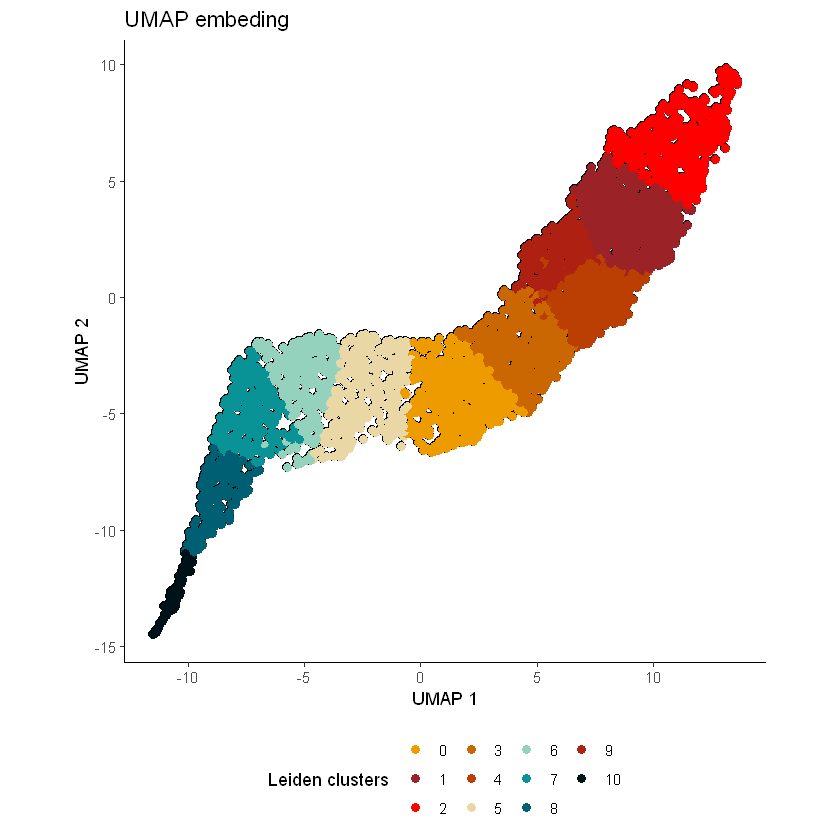

In [7]:
plot_dimred(model_paga, grouping = group_onto_nearest_milestones(model_paga), label_milestones=TRUE, plot_trajectory = FALSE)+
theme_classic()+
theme(legend.position = "bottom")+
labs(title = "UMAP embeding",
       x = "UMAP 1",
       y = "UMAP 2")+
scale_color_manual(values=color,name = "Leiden clusters",
                  breaks = c("0","1","2","3","4","5","6","7","8","9","10","11","12","13","14"))

# Interpreting the trajectory biologically

In most cases, some knowledge is present of the different start, end or intermediary states present in the data, and this can be used to adapt the trajectory so that it is easier to interpret.

Most methods have no direct way of inferring the directionality of the trajectory. In this case, the trajectory should be “rooted” using some external information, for example by using a set of marker. The cluster N°10 presents a protein component (and an absence of lipid component). This cluster corresponds to the spectra acquired on very small lipidic droplets, while cluster N°2 (presenting lipidic component) corresponds to the spectra acquired on the largest lipid droplets. 

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Warning message:
"Removed 1749 row(s) containing missing values (geom_path)."
Warning message:
"Removed 3806 row(s) containing missing values (geom_path)."


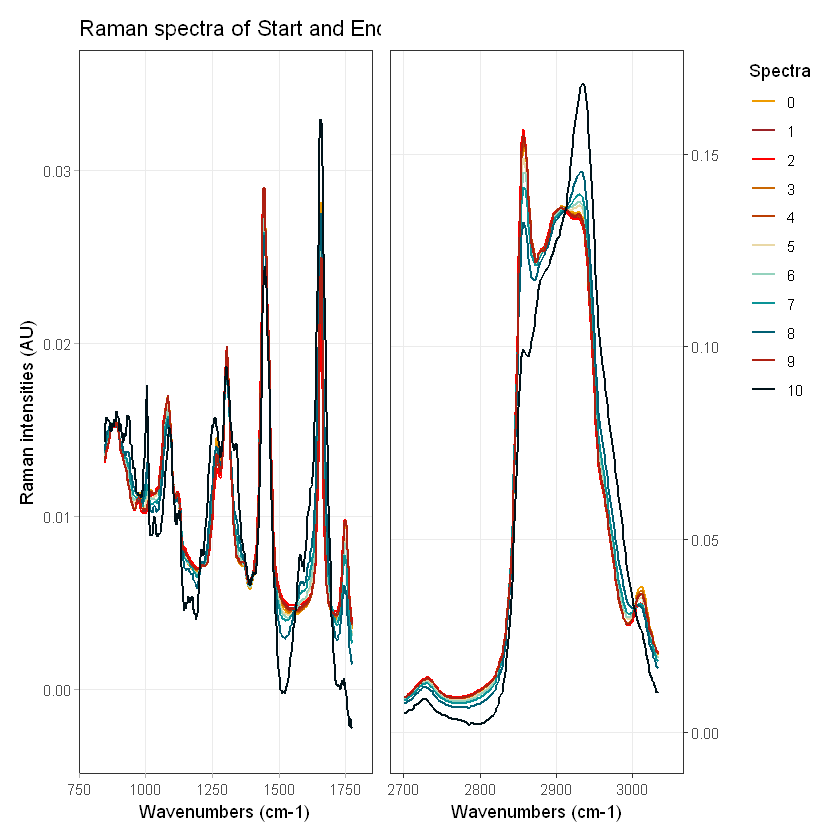

In [14]:
library(ggbreak) 
width = 15 
height =8

group_id <- data.frame(as.numeric(model_paga$grouping))
colnames(group_id)<-c('Leiden')
colnames(mydata) <- WL
dat <- data_frame(group_id, mydata)
cluster <- aggregate(dat, by=dat[1], FUN=mean)
cluster <- cluster[-2]
cluster2 <- melt(cluster ,  id.vars = 'Leiden')
cluster2$variable <- as.numeric(as.character(cluster2$variable))
cluster2$Leiden <- factor(as.character(cluster2$Leiden), levels = as.character(0:(length(model_paga$group_id)-1)))


c <- ggplot(cluster2, aes(x = variable, y = value))+
    geom_line(aes(color = Leiden), size = 0.8, linetype = "solid", show.legend = FALSE) +
    theme_bw()+
    theme(legend.position = "right",
    legend.background = element_rect(fill = "white", size = 4, colour = "white"),
    legend.justification = c(0, 1),
   
    axis.ticks = element_line(colour = "grey70", size = 0.2),

    panel.grid.minor = element_blank()) +
    xlab("Wavenumbers (cm-1)")+
     xlim(800,1800)+
     ylim(-0.003,0.035)+
   
    #scale_x_break(c(1750, 2700))+
    #scale_y_break(c(0.05, 0.08))+

    ylab("Raman intensities (AU)")+
    labs(title = "Raman spectra of Start and Ends of trajectories")+
    scale_color_manual(values=c(color[0:15]),name = "Spectra",
                      breaks = c("0","1","2","3","4","5","6","7","8","9","10","11","12","13","14"))


d <- ggplot(cluster2, aes(x = variable, y = value))+
    geom_line(aes(color = Leiden), size = 0.8, linetype = "solid") +
    theme_bw()+
    theme(legend.position = "right", 
          
          axis.title.y=element_blank(),
          legend.background = element_rect(fill = "white", size = 4, colour = "white"),
          legend.justification = c(0, 1),
          panel.grid.minor = element_blank()) +
    xlab("Wavenumbers (cm-1)")+
     xlim(2700,3050)+
     ylim(-0.003,0.17)+
    scale_y_continuous(position = "right")+
    #scale_x_break(c(1750, 2700))+
    #scale_y_break(c(0.05, 0.08))+

    scale_color_manual(values=c(color[0:15]),name = "Spectra",
                      breaks = c("0","1","2","3","4","5","6","7","8","9","10","11","12","13","14"))

#ggsave(file="centroides_adipo.svg", plot=c +d, width=width, height=height, bg = "transparent")
#ggsave(file="centroides_adipo.tiff", plot=c + d , width=width, height=height, bg = "transparent")

c+d

To help choosing the root cluster it is also possible to display some Raman frequencies of biological interest

Coloring by expression

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Coloring by expression

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Coloring by expression

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Coloring by expression

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Coloring by expression

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Coloring by expression

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



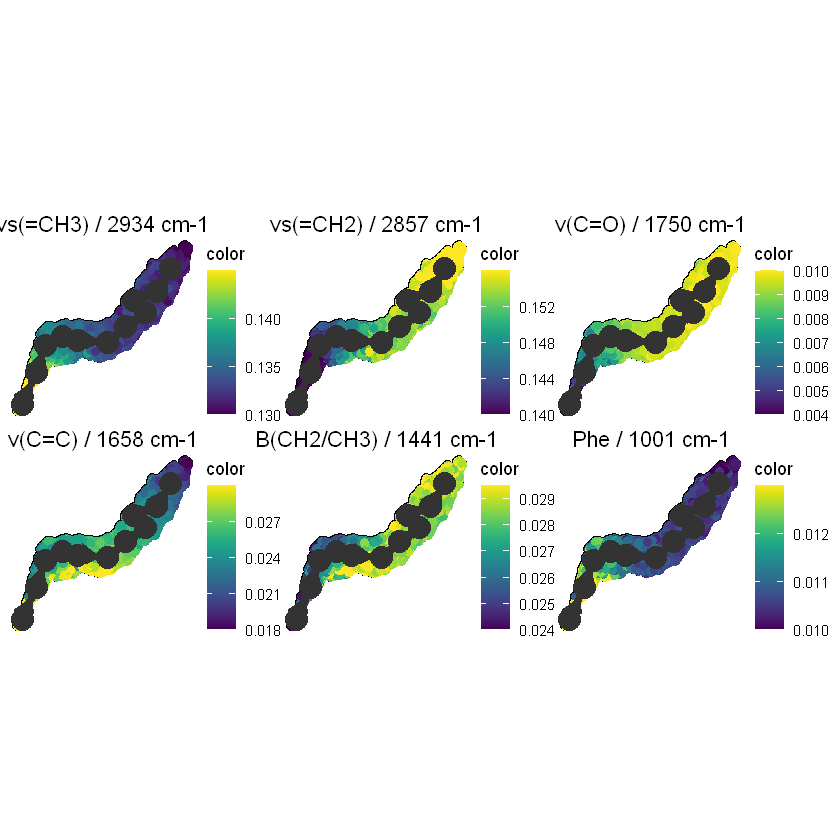

In [20]:
patchwork::wrap_plots(   
  plot_dimred(model_paga_rooted, feature_oi = c("2934 cm-1"), label_milestones=FALSE, plot_trajectory =TRUE,expression_source = dataset)+ ggtitle("vs(=CH3) / 2934 cm-1")+ theme(legend.position = "right")+
    scale_colour_gradientn(colours = viridis(100),na.value = "grey50",limits=c(0.13, 0.145),
                           oob = scales::squish, 
                           position = "right"),
    
  plot_dimred(model_paga_rooted, feature_oi = c("2857 cm-1"), label_milestones=FALSE, plot_trajectory = TRUE, expression_source = dataset)+ ggtitle("vs(=CH2) / 2857 cm-1")+ theme(legend.position = "right")+
    scale_colour_gradientn(colours = viridis(100),na.value = "grey50",limits=c(0.14, 0.156),
                           oob = scales::squish, 
                           position = "right"),
    
    plot_dimred(model_paga_rooted, feature_oi = c("1750 cm-1"), label_milestones=FALSE, plot_trajectory = TRUE, expression_source = dataset)+ ggtitle("v(C=O) / 1750 cm-1")+ theme(legend.position = "right")+
    scale_colour_gradientn(colours = viridis(100),na.value = "grey50",limits=c(0.004, 0.01),
                           oob = scales::squish, 
                           position = "right"),
    
    plot_dimred(model_paga_rooted, feature_oi = c("1658 cm-1"), label_milestones=FALSE, plot_trajectory = TRUE, expression_source = dataset)+ ggtitle("v(C=C) / 1658 cm-1")+ theme(legend.position = "right")+
    scale_colour_gradientn(colours = viridis(100),na.value = "grey50",limits=c(0.018, 0.03),
                           oob = scales::squish, 
                           position = "right"),
    
    plot_dimred(model_paga_rooted, feature_oi = c("1441 cm-1"), label_milestones=FALSE, plot_trajectory = TRUE, expression_source = dataset)+ ggtitle("B(CH2/CH3) / 1441 cm-1")+ theme(legend.position = "right")+
    scale_colour_gradientn(colours = viridis(100),na.value = "grey50",limits=c(0.024, 0.0295),
                           oob = scales::squish, 
                           position = "right"),
    
    
    plot_dimred(model_paga_rooted, feature_oi = c("1004 cm-1"), label_milestones=FALSE, plot_trajectory = TRUE, expression_source = dataset)+ ggtitle("Phe / 1001 cm-1")+ theme(legend.position = "right")+
    scale_colour_gradientn(colours = viridis(100),na.value = "grey50",limits=c(0.010, 0.013),
                           oob = scales::squish, 
                           position = "right"))


Cluster 10 is designated as the root of the differenciation process 

In [11]:
model_paga_rooted <- model_paga %>% add_root(root_milestone_id = "10")
model_paga_rooted <- add_pseudotime(model_paga_rooted)
model_paga_rooted <- add_expression(model_paga_rooted, expression = dataset$expression, counts = dataset$expression)

# Cell ordering / Pseudotime Estimation 

The distance to the root cluster (N°10). 

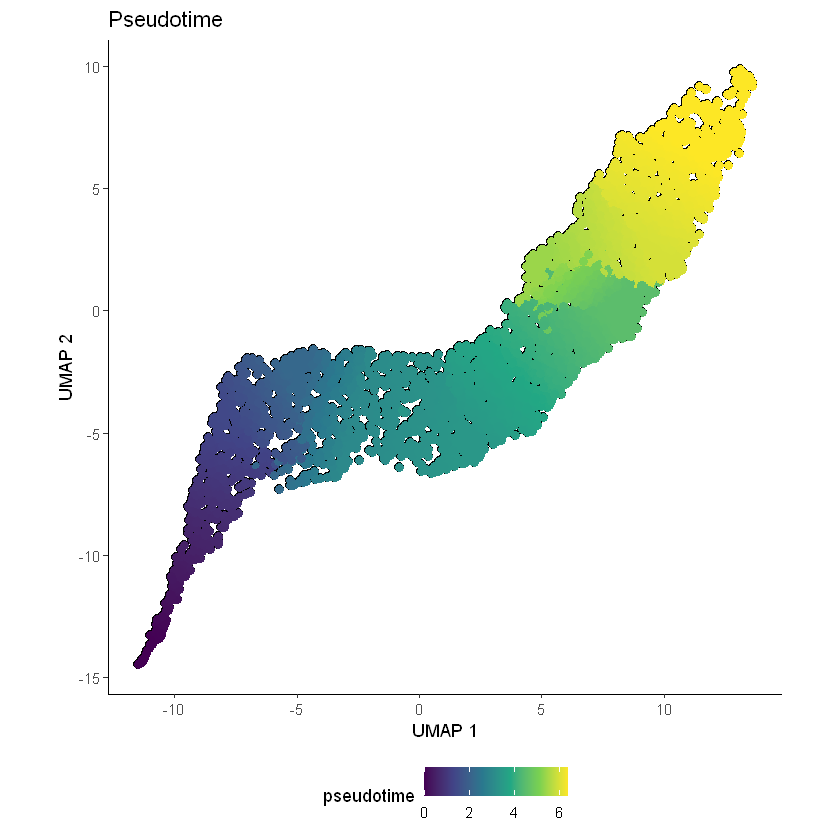

In [12]:
plot_dimred(model_paga_rooted, expression_source = dataset$expression, color_cells = "pseudotime",
                 plot_trajectory = FALSE,label_milestones=FALSE)+
theme_classic()+
theme(legend.position = "bottom")+
labs(title = "Pseudotime",
       x = "UMAP 1",
       y = "UMAP 2")

# Milestone labelling

Milestones can be labelled using marker genes. These labels can then be used for subsequent analyses and for visualisation.

Coloring by grouping

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



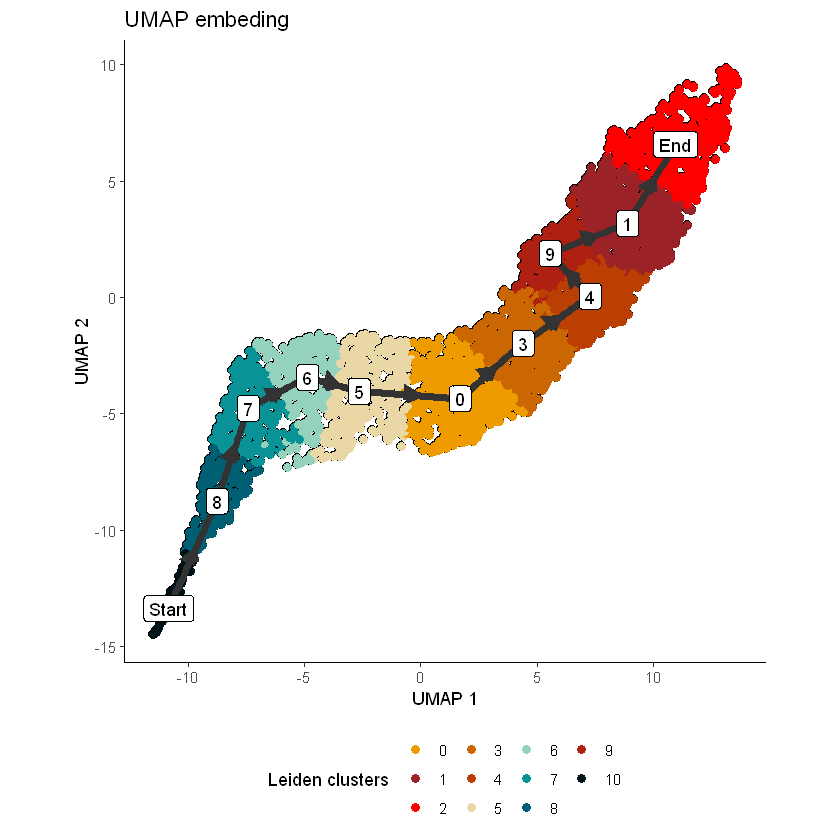

In [13]:
labeled_model_paga_rooted <- model_paga_rooted %>% label_milestones(c("0" = "0",
                                                           "1" = "1",
                                                           "2" = "End",
                                                           "3" = "3",
                                                           "4" = "4",
                                                           "5" = "5",
                                                           "6" = "6",
                                                           "7" = "7",
                                                           "8" = "8",
                                                           "9"= "9",
                                                            "10"="Start"  
                                                           ))


plot_dimred(labeled_model_paga_rooted, grouping = group_onto_nearest_milestones(model_paga), 
            label_milestones=TRUE, plot_trajectory = TRUE)+
theme_classic()+
theme(legend.position = "bottom")+
labs(title = "UMAP embeding",
       x = "UMAP 1",
       y = "UMAP 2")+
scale_color_manual(values=color,name = "Leiden clusters",
                  breaks = c("0","1","2","3","4","5","6","7","8","9","10","11","12","13","14"))


# Additional plotting 

This figure shows that at a specific kinetic time it is still possible to find cells with poorly developed lipid droplets 

Coloring by grouping

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



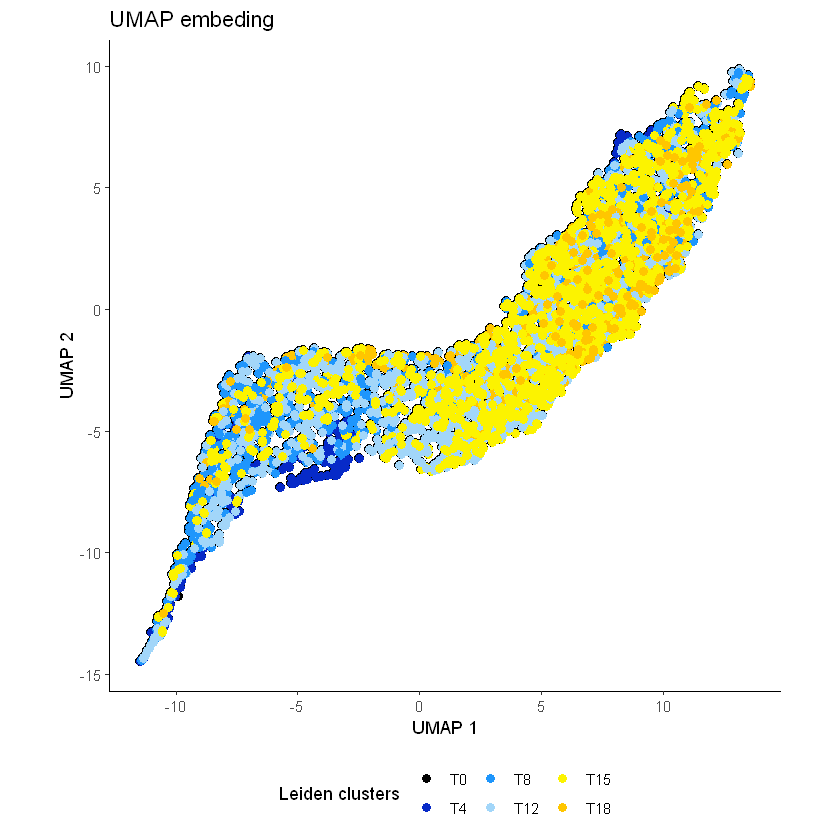

In [16]:
palette_time <- c('#000000','#072AC8','#1E96FC','#A2D6F9','#FCF300','#FFC600')

plot_dimred(model_paga_rooted, grouping = OBS$Label,label_milestones=FALSE, alpha = 1, plot_trajectory = FALSE)+
theme_classic()+
theme(legend.position = "bottom")+
labs(title = "UMAP embeding",
       x = "UMAP 1",
       y = "UMAP 2")+
scale_color_manual(values=palette_time,name = "Leiden clusters",
                   breaks = c("T0","T4","T8","T12","T15","T18"))

Percentage of cluster present at each kinetic time 


  T0   T4   T8  T12  T15  T18 
   5  175  789 1190 1782  573 

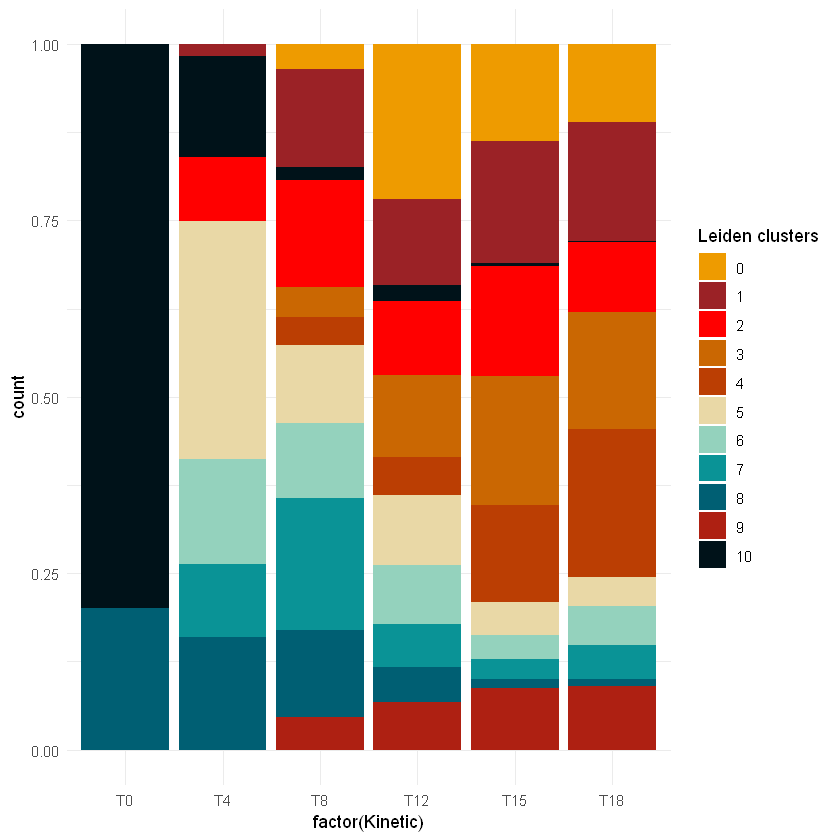

In [17]:
kinetic <- data.frame(OBS$Label)
Leiden <- data.frame(group_onto_nearest_milestones(model_paga))
cluster_occurence <- cbind(kinetic,Leiden)
colnames(cluster_occurence) <- c('Kinetic', 'Cluster')
cluster_occurence$Kinetic = factor(cluster_occurence$Kinetic, levels = c('T0', 'T4', 'T8','T12','T15','T18'))
ggplot() + 
theme_minimal()+
    geom_bar(data = cluster_occurence,
             aes(x = factor(Kinetic),fill = factor(Cluster)),
             position = "fill")+
scale_fill_manual(values=color,name = "Leiden clusters",
                  breaks = c("0","1","2","3","4","5","6","7","8","9","10","11"))
table(cluster_occurence$Kinetic)

# Trajectory Visualisation 

A global overview of the most informatives Raman intensisies 

In [18]:
overall_feature_importances <- dynfeature::calculate_overall_feature_importance(model_paga_rooted)
features <- overall_feature_importances %>% 
  top_n(50, importance) %>% 
  pull(feature_id)

Coloring by milestone



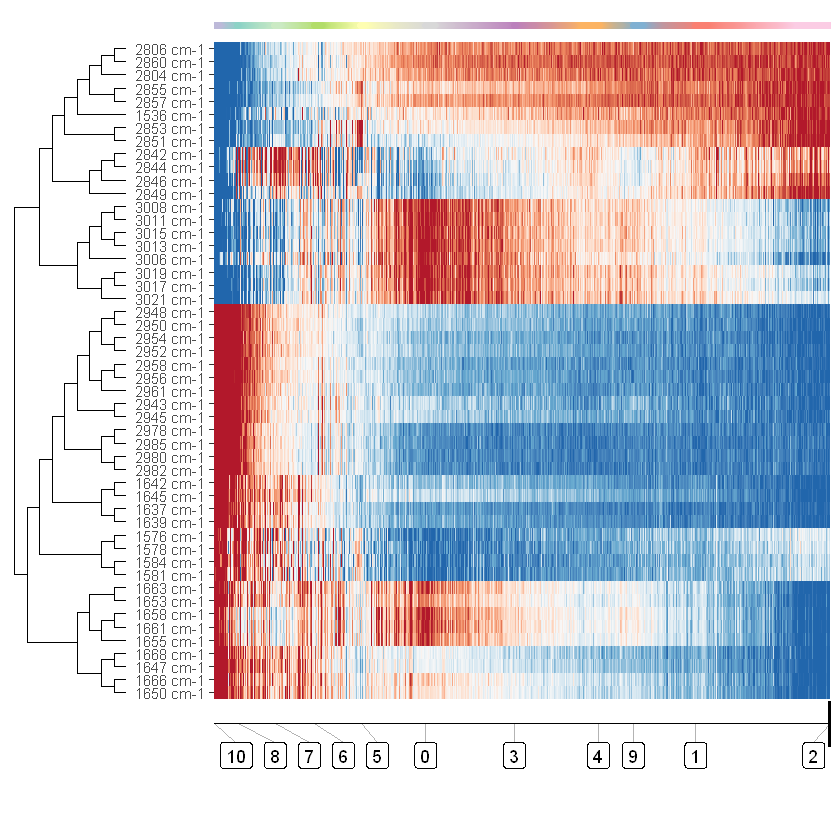

In [19]:
plot_heatmap(model_paga_rooted,
             expression_source = dataset$expression,                      
             features_oi = features,
             clust = "ward.D2",    
             margin = 0.03,
             scale = dynutils::scale_quantile
             )